# **Pràctica 2 - L'enfonsament del Titànic i les possiblitats de sobreviure**
## Inteligència Artificial - Machine Learning
### Grau en Enginyeria Informàtica - Universitat de les Illes Balears

#### Autors: Lluis Barca Pons i Victor Canelo Galera

Desde l'assignatura d'Intelgència Artificial se'ns ha demanat realitzar un anàlisis sobre el famós enfonsament del vaixell Titànic, l'any 1912. Durant aques naufragi, van morir 1502 de 2224 persones registrades, entre passatgers i tripulants.

El més interessant és que sembla ser que existia diferents probabilitats de sobreviure entre alguns grups de persones. Per tant, l'objectiu d'aquesta pràctica és realitzar un model predictiu, utilizant les dades reals recollides, que ens mostri quins tipus de persones tenien més probabiitats de viure.

Llavors, la practica es dividira en dues parts:

1. Entrenar una serie de predictors i comparar el seu rendiment.

2. Obtenir i analitzar la importancia de cada caracteristica per cada un dels models generats.

# 1.Configuració del nostre entorn

A continuació tenim els corresponents imports de les diferents llibreries de Python que utilitzarem durant tota la pràctica.

In [346]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier 

## 1.1. Anàlisis del dataset

In [347]:
df = pd.read_csv("dades.csv")
df


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [348]:
# Eliminam les variables Name i Ticket perquè no es poden substituir per nombres
del df["Name"]
del df["Ticket"]

# Modificam la variable Sex
df = df.replace(to_replace="male", value=0)
df = df.replace(to_replace="female", value=1)

# Calculam la mitjana d'edat de la gent del vaixell
edat = df[["Age"]]
edat = edat.dropna()
edat = int(edat.mean())
edat = float(edat)

df["Age"] = df["Age"].replace(np.nan, str(edat))

# Modificam el valor Cabin per saber si el passatger té cabina o no
df["Cabin"] = df["Cabin"].notnull().astype("int")

# Modificam el calor Embarked per 1, 2, 3 segons el port d'embarcament
df["Embarked"] = df["Embarked"].replace(to_replace="S", value=1)
df["Embarked"] = df["Embarked"].replace(to_replace="C", value=2)
df["Embarked"] = df["Embarked"].replace(to_replace="Q", value=3)

df


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0,1.0
1,2,1,1,1,38.0,1,0,71.2833,1,2.0
2,3,1,3,1,26.0,0,0,7.9250,0,1.0
3,4,1,1,1,35.0,1,0,53.1000,1,1.0
4,5,0,3,0,35.0,0,0,8.0500,0,1.0
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000,0,1.0
887,888,1,1,1,19.0,0,0,30.0000,1,1.0
888,889,0,3,1,29.0,1,2,23.4500,0,1.0
889,890,1,1,0,26.0,0,0,30.0000,1,2.0


En primer lloc realitzarem una correlacio de totes les variables per analitzar quines ens poden interessar i quines no.

<AxesSubplot: >

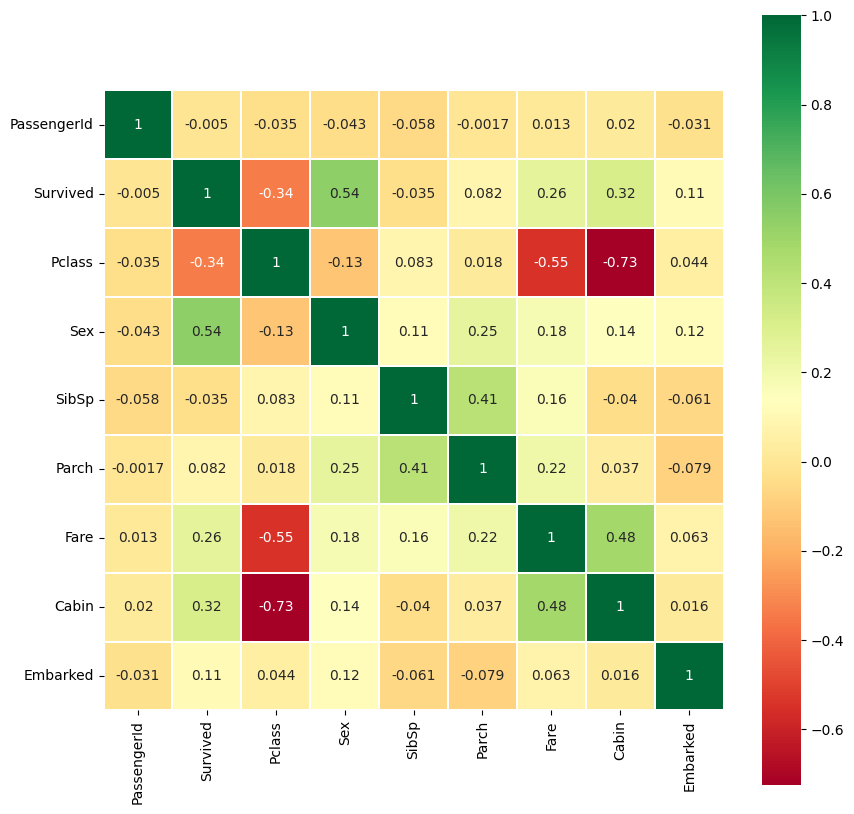

In [349]:
corr_fig = plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, square=True, cmap="RdYlGn", linewidths=0.2)

Llavors, les variables que més ens interessen són les que comparades amb "Survived", prenen valors o molt a prop de 1 o de -1; és a dir, que tindran molta correlació.

A continuació la visualització gràfica d'aquestes variables per a una millor comprensió de les dades.

## 1.2. Neteja del Dataset

A continuació descartarem algunes variables que no ens aporten cap informació rellevant sobre la probabilitat de sobreviure. 

- PassengerId: ID del passatjer
- Name: El nom de cada tripulant
- SibSp: Germans / cònjuges pròxims a bord 
- Parch: Pares / Fills a bord
- Ticket: El nombre del ticket
- Fare: Tarifa pagada
- Embarked: Port d'embarcament

A continuació, observam les variables que contenguin valors no numèrics:

In [ ]:
df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Sex            False
Age            False
SibSp          False
Parch          False
Fare           False
Cabin          False
Embarked        True
dtype: bool

Ens adonam que tres de les dotze variables tenen valors no numèrics. Però, ens interessa saber quin tant per cent de les files no ens donen cap informació.

In [ ]:
na_ratio = ((df.isnull().sum() / len(df))*100).sort_values(ascending = False)
print(na_ratio)

Embarked       0.224467
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Fare           0.000000
Cabin          0.000000
dtype: float64


Llavors, la variable Cabin, tampoc serà adequada per a la realització del model, ja que el nombre de valors no numèrics és molt elevat. No obstant, la variable Age també ens mostra un tant per cent notable de nombres no numèrics. Però, aquesta variable ens dona informació rellevant i podem substituir les dades no numeriques per la mitjana d'edat que trobem al vaixell. D'aquesta forma podem mantenir la variable.

In [ ]:
model = df[["Survived","Pclass", "Sex", "Age", "SibSp", "Parch"]]

# Calculam la mitjana d'edat de la gent del vaixell
edat = df[["Age"]]
edat = edat.dropna()
edat = int(edat.mean())
edat = float(edat)

model["Age"] = model["Age"].replace(np.nan, str(edat))
# model["Age"] = model["Age"].fillna(str(edat))

/tmp/ipykernel_3055/401874635.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  edat = int(edat.mean())


TypeError: cannot convert the series to <class 'int'>

A continuació, modificarem el valor del sexe per Male = 0 i Female = 1; per poder entrenar el nostre model.

In [ ]:
model = model.replace(to_replace="male", value="0")
model = model.replace(to_replace="female", value="1")

I per finalitzar, ens queden les variables SibSp i Parch, que ens indiquen el nombre de germans o conjugues propers al vaixell y el nombre de fills o pares, respectivament. Com aquesta dada podria influenciar a l'hora de pujar a un bot salvavides o simplement que una persona quan no va acompanyada, nomes s'ha de preocupar de la seva propia vida.

In [ ]:
sibsp = model["SibSp"]
parch = model["Parch"]
family = []

# Cream la nova columna family
for i in range(len(sibsp)):
    family.append(sibsp[i] + parch[i])

# Eliminam les variables sibsp i parch del dataset
del model["SibSp"]
del model["Parch"]

# Afegim la columna family
model.insert(4, "Family", family, True)

Una vegada feta la neteja, ens quedaria el següent dataset:

In [ ]:
model

,Survived,Pclass,Sex,Age,Family
0,0,0,0,0,0
1,1,1,1,1,2
2,0,0,0,0,0
3,1,1,1,1,2
4,0,0,0,0,0
...,...,...,...,...,...
886,0,0,0,0,0
887,1,1,1,1,2
888,0,0,0,0,0
889,1,1,1,1,2


# 2. Entrenament

A continuació es duran a terme una serie d'entrenaments segons diferents predictors i finalment es compararan els seus rendiments. 

Abans però, haurem de separar el nostre conjunt de dades per a entrenament, validació i testeig. També normalitzarem les dades per a que les poguem comparar entre elles.

In [ ]:
scaler = preprocessing.MinMaxScaler()

y = model["Survived"]
x = model.drop("Survived", axis=1)

# Escalam les dades en funció de x
x = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25, stratify=y , random_state=42)

## 2.1. Regressió Logística

Hem decidit baixar el nombre de ```max_iter``` ja que el nombre d'iteracions base no és necessari. Ens dona el mateix resultat fent menys iteracions.

In [ ]:
log = LogisticRegression(random_state=0, max_iter=25).fit(x_train, y_train)
y_hat = log.predict(x_test)

print(classification_report(y_test, y_hat, target_names=["Viu", "Mort"]))

              precision    recall  f1-score   support

         Viu       1.00      1.00      1.00       172
        Mort       1.00      1.00      1.00        51

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223



## 2.2. Perceptró

Com tenim divisions entre 0, hem decidit substituir-les per el valor 1.

In [ ]:
perc = Perceptron(random_state=0).fit(x_train, y_train)
y_hat = perc.predict(x_test) 

print(classification_report(y_test, y_hat, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00        51

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223



## 2.3. Arbres de decissió

Com tenim divisions entre 0, hem decidit substituir-les per el valor 1.

In [ ]:
forest = RandomForestClassifier(random_state=0).fit(x_train, y_train)

print(classification_report(y_test, y_hat, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00        51

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223



## 2.4. Comparació dels rendiments

Després de veure els resultats de cada predictor, ens adonem que el que ens dona una major precissió és el de Regressió Logistica.

# 3. Anàlisis de les característiques

# 4. Conclusions